In [1]:
%matplotlib notebook
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

<IPython.core.display.Javascript object>


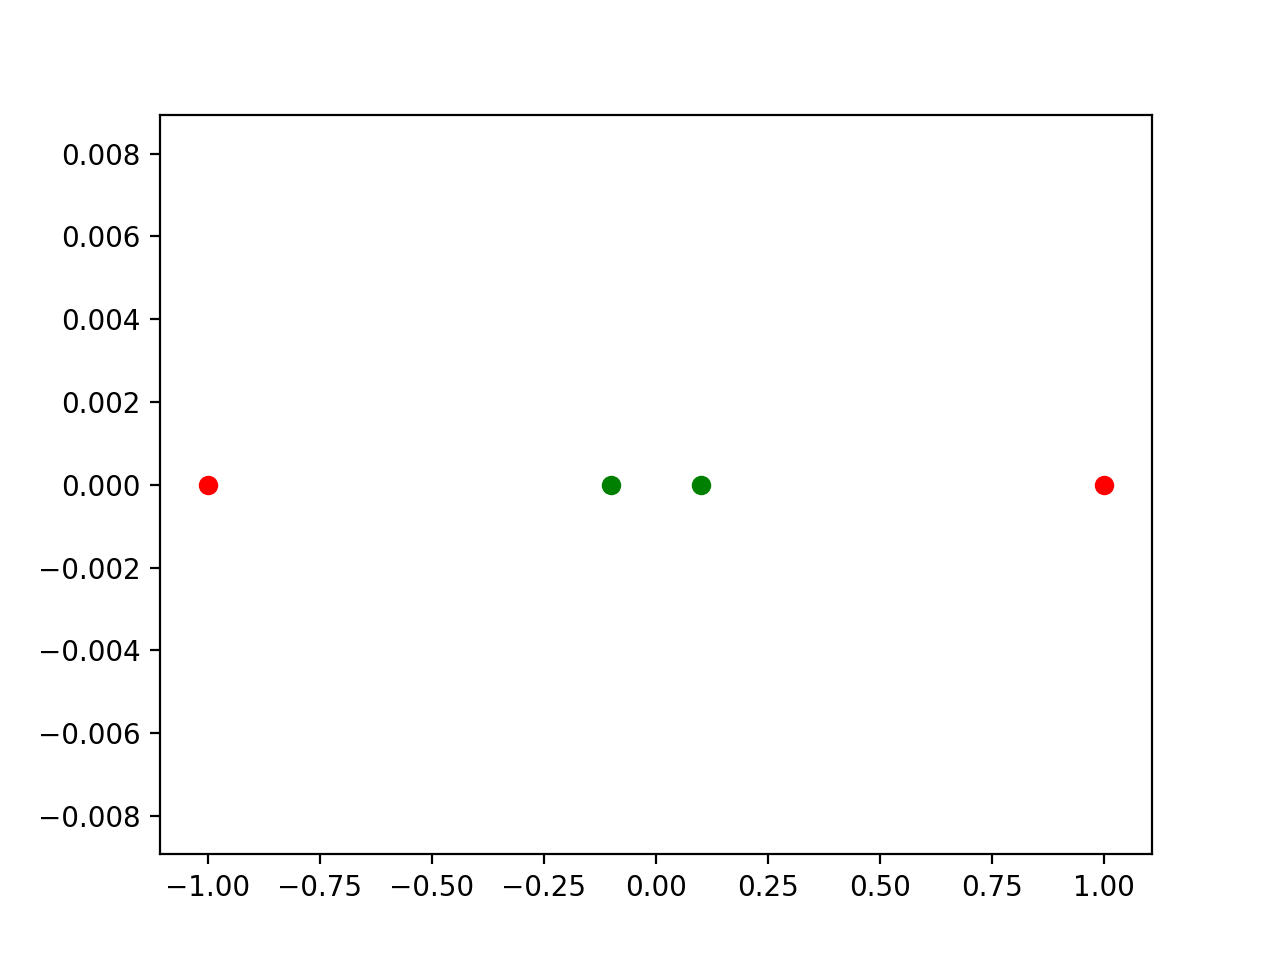

In [2]:
random.seed(3)

def rand_cluster(n,c,r):
    """returns n random points in disk of radius r centered at c"""
    x = c
    points = []
    for i in range(n):
        theta = 2*math.pi*random.random()
        s = r*random.random()
        points.append([x+s*math.cos(theta)])
    return points

def rand_clusters(k,n,r, a,b,c,d):
    """return k clusters of n points each in random disks of radius r
    where the centers of the disk are chosen randomly in [a,b]x[c,d]"""
    clusters = []
    for _ in range(k):
        x = a + (b-a)*random.random()
        y = c + (d-c)*random.random()
        clusters.extend(rand_cluster(n,x,r))
    return clusters

n = 2
X = rand_clusters(2,n,0.8,-1,1,-1,1)
data = np.array(X)
label = np.transpose(np.array([[1]*n + [0]*n]))

# label = np.array([1]*n + [0]*n)
data = []
label = []
data.append([-1])
data.append([1])
data.append([0.1])
data.append([-0.1])
label.append([1])
label.append([1])
label.append([0])
label.append([0])
data = np.array(data)
label = np.array(label)
# print (data, label)

plt.scatter(data[:n], [0]*n, color=['red'])
plt.scatter(data[n:], [0]*n, color=['green'])
plt.show()

In [13]:
# tf.reset_default_graph()

# def weight_variable(shape, name):
#     initial = tf.truncated_normal(shape=shape, stddev=0.1)
#     return tf.get_variable(name=name, initializer=initial)

# def bias_variable(shape, name):
#     initial = tf.constant(0.1, shape=shape)
#     return tf.get_variable(name=name, initializer=initial)


x = tf.placeholder(tf.float32, [None, 1])
y_ = tf.placeholder(tf.float32, [None, 1])


n_input = 1
n_hidden = 2
n_output = 1
lmd = 0

parameters = tf.Variable(tf.concat([tf.truncated_normal([n_input * n_hidden]), tf.truncated_normal([n_hidden]),\
                                    tf.truncated_normal([n_hidden * n_output]), tf.truncated_normal([n_output]),\
                                   ], 0))

idx_from = 0 
weights1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_input*n_hidden]), [n_input, n_hidden])
idx_from = idx_from + n_input*n_hidden
biases1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden]), [n_hidden])
hidden = tf.nn.relu(tf.matmul(x, weights1) + biases1)

idx_from = idx_from + n_hidden
weights2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden*n_output]), [n_hidden, n_output])
idx_from = idx_from + n_hidden*n_output
biases2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_output]), [n_output])
y = tf.nn.relu(tf.matmul(hidden, weights2) + biases2)

loss = tf.reduce_mean(tf.reduce_sum(tf.pow(y_ - y, 2), reduction_indices=[1])) #I also tried simply tf.nn.l2_loss(y_ - y)

lr = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
grads_and_vars = optimizer.compute_gradients(loss)
grad = tf.gradients(loss, parameters)
hess = tf.hessians(loss, parameters)
train_step = optimizer.apply_gradients(grads_and_vars)

In [14]:
def get_accuracy():
    pred = sess.run(y, feed_dict={x: data, y_: label})    
    match = [(pred[i] - 0.5) * (label[i] - 0.5) > 0  for i in range(n*2)]
    acc = sum(match)*1./2/n
    return acc[0]

def get_norm_grad():
    nng = 0.
    for gv in grad:
#         print(str(sess.run(gv[0], feed_dict={x: data, y_: label})) + " - " + gv[1].name)
        g = sess.run(gv, feed_dict={x: data, y_: label})
#         print (g)
        nng += np.linalg.norm(g) ** 2
    return np.sqrt(nng)
    
     
def displayH(a):
    a = np.array(a[0])
#     print ("Matrix["+("%d" %a.shape[0])+"]["+("%d" %a.shape[1])+"]")
    rows = a.shape[0]
    cols = a.shape[1]
    for i in range(0, rows):
        for j in range(0, cols):
            print("%0.2g " %a[i,j], end="")
        print ()
    print ()

In [30]:
sess = tf.InteractiveSession()
l = 2e-1
dic = {}
nr = 20
ni = 30

cmap = cm.brg  # nipy_spectral, Set1, Paired, brg
colors = cm.jet(np.linspace(0.8, 0.3, ni+1))
colors[:, 1] = np.linspace(0.5, 0.5, ni+1)
colors[:, 2] = np.linspace(0., 0.0, ni+1)

for r in range(nr):
    
    dic[r] = {}
    dic[r]['w1'] = np.zeros(ni+1)
    dic[r]['w2'] = np.zeros(ni+1) 
    dic[r]['w3'] = np.zeros(ni+1) 
    dic[r]['s'] = np.zeros(ni+1)
    
    tf.global_variables_initializer().run()
    w = sess.run([parameters], feed_dict={x: data, y_: label, lr: l})
    nng = get_norm_grad()
    dic[r]['w1'][0] = w[0][2]
    dic[r]['w2'][0] = w[0][3]
    dic[r]['w2'][0] = w[0][6]
    dic[r]['s'][0] = max(v,1e-5)
 
    for i in range(1,ni+1):
        sess.run(train_step, feed_dict={x: data, y_: label, lr: l})
        v, w = sess.run([loss, parameters], feed_dict={x: data, y_: label})    
        nng = get_norm_grad()
        dic[r]['w1'][i] = w[2]
        dic[r]['w2'][i] = w[3]
        dic[r]['w3'][i] = w[6]
        dic[r]['s'][i] = max(v,1e-5)

    v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
    nng = get_norm_grad()
    eigs = sorted(np.linalg.eigvals(H)[0])
    print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
            .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:]), max(eigs), min(eigs) ))


sess.close() 

Epoch 31, accuracy 75.00%, loss 0.250078, nng 0.007626, nnw 2.098, high_eig 4.392, low_eig -0.0004669.
Epoch 31, accuracy 50.00%, loss 0.500000, nng 0, nnw 2.409, high_eig 0, low_eig 0.
Epoch 31, accuracy 50.00%, loss 0.500000, nng 0, nnw 2.662, high_eig 0, low_eig 0.
Epoch 31, accuracy 50.00%, loss 0.500000, nng 0, nnw 2.166, high_eig 0, low_eig 0.
Epoch 31, accuracy 50.00%, loss 0.500000, nng 0, nnw 0.6579, high_eig 0, low_eig 0.
Epoch 31, accuracy 50.00%, loss 0.500000, nng 0, nnw 2.385, high_eig 0, low_eig 0.
Epoch 31, accuracy 75.00%, loss 0.178761, nng 0.08096, nnw 2.643, high_eig 2.481, low_eig -0.06189.
Epoch 31, accuracy 100.00%, loss 0.000751, nng 0.03358, nnw 2.388, high_eig 5.765, low_eig -0.003873.
Epoch 31, accuracy 50.00%, loss 0.500000, nng 0, nnw 2.449, high_eig 0, low_eig 0.
Epoch 31, accuracy 75.00%, loss 0.250000, nng 7.413e-05, nnw 2.352, high_eig 1.242, low_eig -5.474e-05.
Epoch 31, accuracy 50.00%, loss 0.500000, nng 0, nnw 2.339, high_eig 0, low_eig 0.
Epoch 31,

<IPython.core.display.Javascript object>


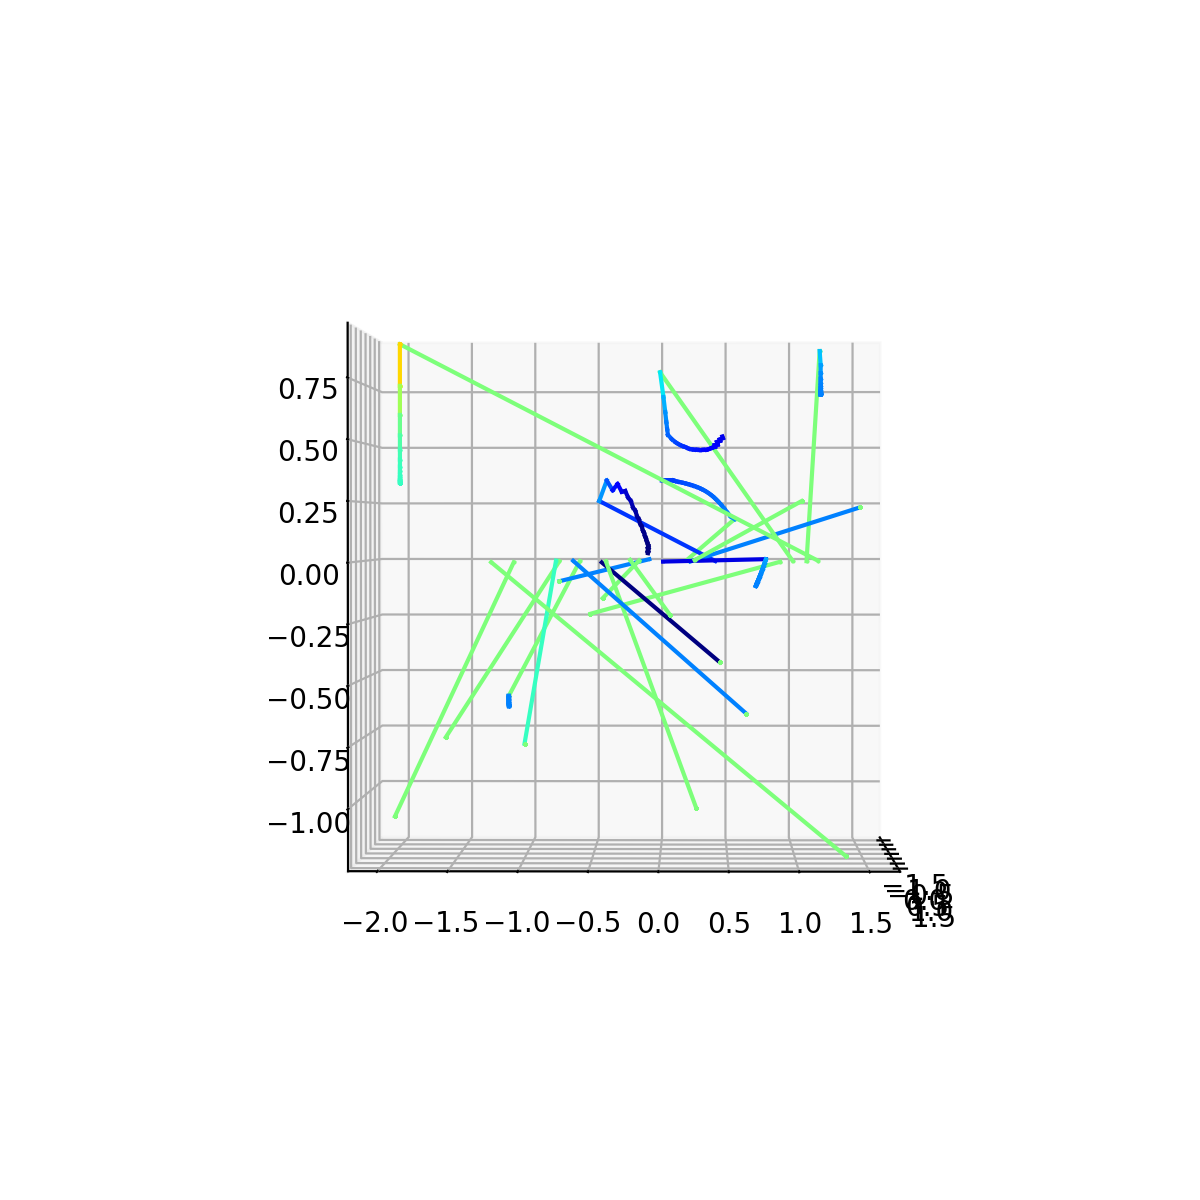

In [32]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
cmap = plt.get_cmap('jet')

for r in range(nr):
#     print ([cm(dic[r]['s'][i]/10) for i in range(ni-1)])
    ax.set_prop_cycle('color', [cmap(dic[r]['s'][i]) for i in range(ni-1)])
    for i in range(ni-1):
        ax.plot(dic[r]['w1'][i:i+2], dic[r]['w2'][i:i+2], dic[r]['w3'][i:i+2]
                , marker='o', markersize=dic[r]['s'][i])

plt.show()